# Environment

In [1]:
! pip install statsmodels --upgrade

     |████████████████████████████████| 8.7MB 2.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)

scipy: 1.4.1
numpy: 1.18.5
matplotlib: 3.2.2
pandas: 1.0.5
sklearn: 0.22.2.post1
statsmodels: 0.11.1


# Problem Description

The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France).

The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data.

The values are a count of millions of sales and there are 105 observations.

In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv

--2020-08-14 15:39:57--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1596 (1.6K) [text/plain]
Saving to: ‘monthly_champagne_sales.csv’

monthly_champagne_s 100%[===================>]   1.56K  --.-KB/s    in 0s      

2020-08-14 15:39:57 (26.3 MB/s) - ‘monthly_champagne_sales.csv’ saved [1596/1596]



# Test Harness

## 3.1 Validation Dataset

In [4]:
import pandas as pd 
series = pd.read_csv('monthly_champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 93, Validation 12


# Persistence

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2899.000, Expected=3370
>Predicted=3370.000, Expected=3740
>Predicted=3740.000, Expected=2927
>Predicted=2927.000, Expected=3986
>Predicted=3986.000, Expected=4217
>Predicted=4217.000, Expected=1738
>Predicted=173

# Data Analysis

## 5.1 Summary Statistics

In [15]:
print(series.describe())

count      105.000000
mean      4761.152381
std       2553.502601
min       1413.000000
25%       3113.000000
50%       4217.000000
75%       5221.000000
max      13916.000000
Name: Sales, dtype: float64


## 5.2 Line Plot

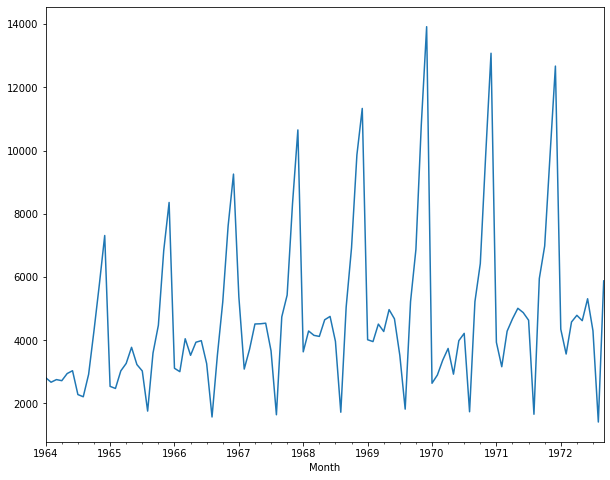

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
series.plot()
plt.show()

## 5.3 Seasonal Line Plots

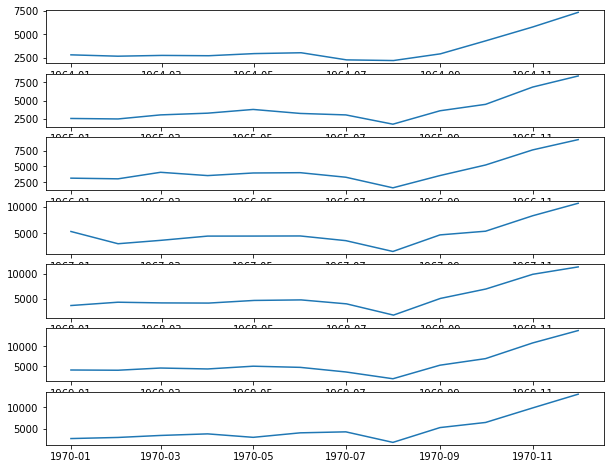

In [20]:
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964':'1970'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
plt.figure(figsize=(10,8))
i = 1
n_groups = len(groups)
for name, group in groups:
	plt.subplot((n_groups*100) + 10 + i)
	i += 1
	plt.plot(group)
plt.show()

## 5.4 Density Plot

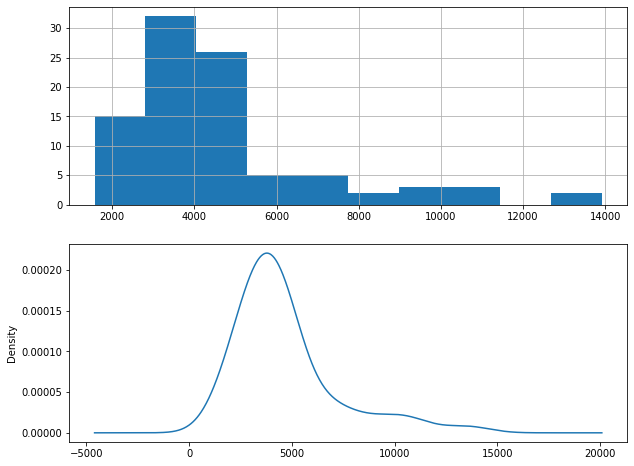

In [23]:
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
plt.figure(1, figsize=(10,8))
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde')
plt.show()

## 5.5 Box and Whisker Plots

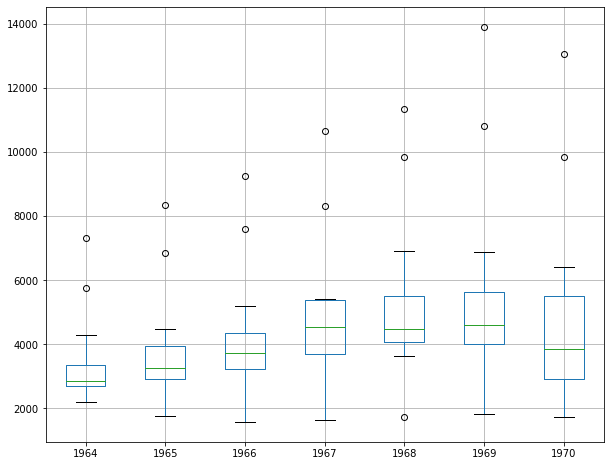

In [25]:
groups = series['1964':'1970'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
	years[name.year] = group.values
plt.figure(figsize=(10,8))
years.boxplot()
plt.show()

# ARIMA Models

## 6.1 Manually Configured ARIMA

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


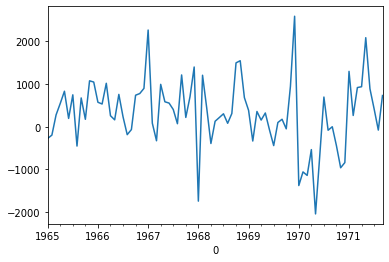

In [26]:
from pandas import read_csv, Series
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
plt.show()

In [28]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

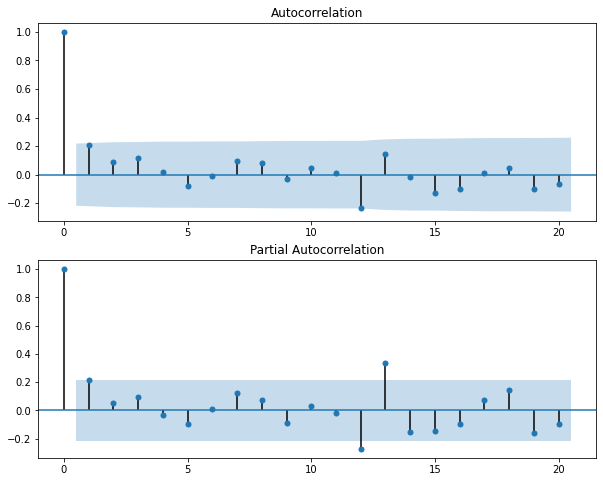

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

series = pd.read_csv('stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
plt.figure(figsize=(10,8))
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

In [32]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=8089.810, Expected=8314
>Predicted=9742.753, Expected=10651
>Predicted=5986.917, Expected=3633
>Predicted=3886.987, Expected=4292
>Predicted=4038.100, Expected=4154
>Predicted=4992.337, Expected=4121
>Predicted=5156.549, Expected=4647
>Predicted=5046.653, Expected=4753
>Predicted=4143.826, Expected=3965
>Predicted=2102.950, Expected=1723
>Predicted=5228.333, Expected=5048
>Predicted=5873.398, Expected=6922
>Predicted=8571.280, Expected=9858
>Predicted=11006.125, Expected=11331
>Predicted=4087.474, Expected=4016
>Predicted=4771.841, Expected=3957
>Predicted=4676.086, Expected=4510
>Predicted=4583.382, Expected=4276
>Predicted=5117.342, Expected=4968
>Predicted=5208.150, Expected=4677
>Predicted=4436.447, Expected=3523
>Predicted=2180.952, Expected=1821
>Predicted=5471.222, Expected=5222
>Predicted=7337.594, Expected=6872
>Predicted=10268.392, Expected=10803
>Predicted=11725.336, Expected=13916
>Predicted=4519.474, Expected=2639
>Predicted=4606.045, Expected=2899
>Predicted=49

## 6.2 Grid Search ARIMA Hyperparameters

In [33]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.790
ARIMA(0, 0, 5) RMSE=986.832
ARIMA(0, 0, 6) RMSE=1087.013
ARIMA(0, 1, 1) RMSE=958.297
ARIMA(0, 1, 2) RMSE=959.958
ARIMA(0, 1, 3) RMSE=975.970
ARIMA(0, 1, 4) RMSE=986.328
ARIMA(0, 1, 5) RMSE=1011.696
ARIMA(0, 1, 6) RMSE=1025.442
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(0, 2, 2) RMSE=987.210
ARIMA(0, 2, 3) RMSE=997.330
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.955
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 0, 1) RMSE=948.800
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.959
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.648
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.939
ARIMA(3, 2, 0) RMSE=1244.847
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.257
ARIMA(4, 2, 0) RMSE=1227.555
ARIMA(4, 2, 1) RMSE=1055.487
ARIMA(5, 0, 0) RMSE=987.690
ARIMA

## 6.3 Review Residual Errors

                 0
count    47.000000
mean    165.904742
std     934.696211
min   -2164.247449
25%    -289.651667
50%     191.759548
75%     732.992187
max    2367.304868


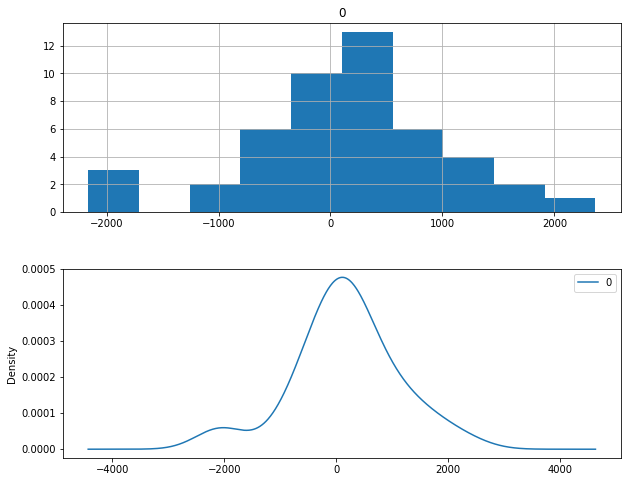

In [34]:
from statsmodels.tsa.arima_model import ARIMA

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure(figsize=(10,8))
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

RMSE: 924.699
                 0
count    47.000000
mean      0.000014
std     934.696211
min   -2330.152177
25%    -455.556395
50%      25.854820
75%     567.087459
max    2201.400140


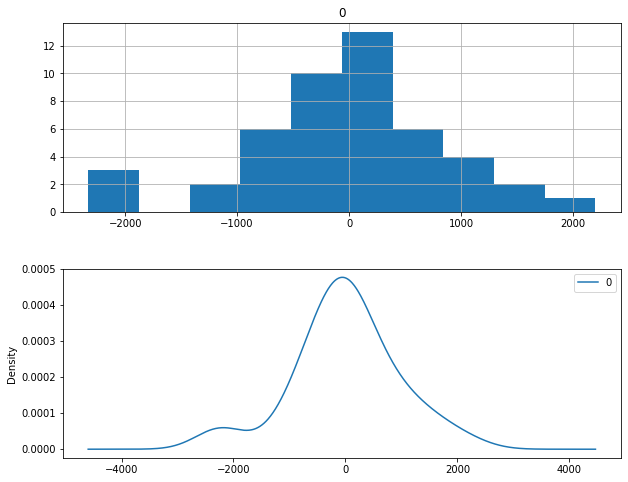

In [36]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.904728
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure(figsize=(10,8))
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

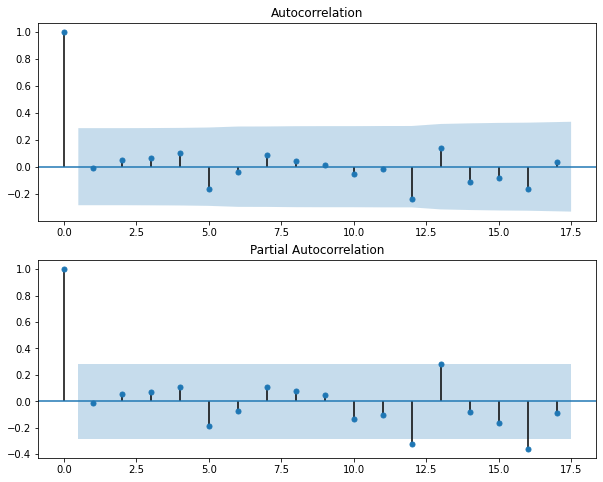

In [39]:
# plot
plt.figure(figsize=(10,8))
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

# Model Validation

In [40]:
## TODO